In [ ]:
 # mount google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
pip install keras-cbam

ERROR: Could not find a version that satisfies the requirement keras-cbam (from versions: none)
ERROR: No matching distribution found for keras-cbam


Move folder

In [ ]:


import shutil
import os

# Absolute paths recommended
folders_to_move = [
    '/content/drive/MyDrive/cataract/dataset/Normal_pupil_filter_img',
    '/content/drive/MyDrive/cataract/dataset/Mild_pupil_filter_img',
     '/content/drive/MyDrive/cataract/dataset/Severe_pupil_filter_img'
]

destination = '/content/drive/MyDrive/cataract/dataset_v3'
os.makedirs(destination, exist_ok=True)

for src_folder in folders_to_move:
    if not os.path.exists(src_folder):
        print(f"❌ Folder not found: {src_folder}")
        continue

    folder_name = os.path.basename(src_folder.rstrip("/"))
    dest_path = os.path.join(destination, folder_name)

    try:
        # If destination exists, remove it first
        if os.path.exists(dest_path):
            shutil.rmtree(dest_path)

        shutil.move(src_folder, dest_path)
        print(f"✅ Moved {folder_name} to {destination}")

    except Exception as e:
        print(f"❌ Error moving {src_folder}: {e}")



✅ Moved Normal_pupil_filter_img to /content/drive/MyDrive/cataract/dataset_v3
✅ Moved Mild_pupil_filter_img to /content/drive/MyDrive/cataract/dataset_v3
✅ Moved Severe_pupil_filter_img to /content/drive/MyDrive/cataract/dataset_v3


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 176s 412ms/step - accuracy: 0.3823 - loss: 1.1272 - val_accuracy: 0.6988 - val_loss: 1.0037 - learning_rate: 1.0000e-04
Epoch 2/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 117s 352ms/step - accuracy: 0.4631 - loss: 1.0522 - val_accuracy: 0.7651 - val_loss: 0.9320 - learning_rate: 1.0000e-04
Epoch 3/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 116s 351ms/step - accuracy: 0.5410 - loss: 0.9711 - val_accuracy: 0.8042 - val_loss: 0.8711 - learning_rate: 1.0000e-04
Epoch 4/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 116s 351ms/step - accuracy: 0.6020 - loss: 0.9053 - val_accuracy: 0.7801 - val_loss: 0.8289 - learning_rate: 1.0000e-04
Epoch 5/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 117s 352ms/step - accuracy: 0.6231 - loss: 0.8811 - val_accuracy: 0.7380 - val_loss: 0.7892 - learning_rate: 1.0000e-04
Epoch 6/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 116s 350ms/step - accuracy: 0.6509 - loss: 0.8501 - val_accuracy: 0.7590 - val_loss: 0.7539 - learning_rate: 1.0000e-04
Epoch 7/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 

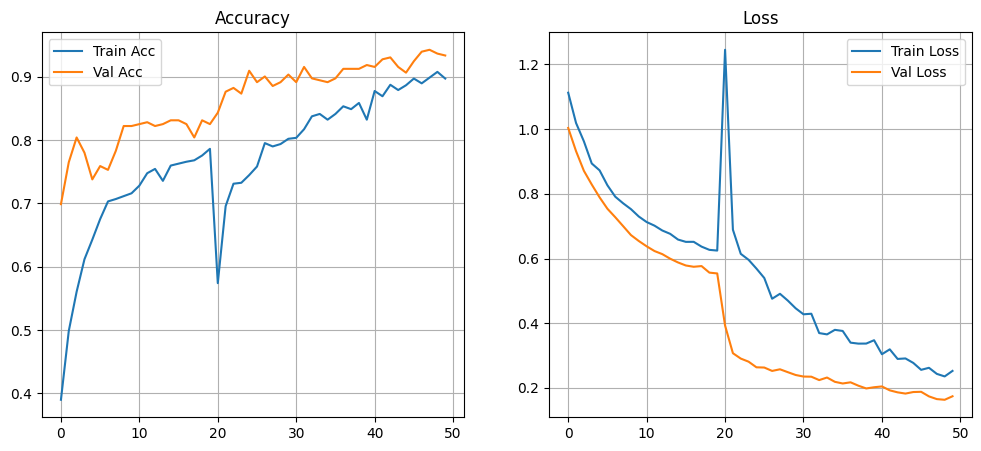

In [ ]:


# ===== 1. Imports =====
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import albumentations as A
from tensorflow.keras.metrics import AUC, Precision, Recall

# ===== 2. Load Dataset =====
dataset_dir =  "/content/drive/MyDrive/cataract/dataset_v3"
class_names = os.listdir(dataset_dir)
img_size = (1024, 1024)
num_classes = len(class_names)

image_paths = []
labels = []

for idx, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_dir, class_name)
    for img_file in os.listdir(class_path):
        if img_file.lower().endswith(('png', 'jpg', 'jpeg')):
            image_paths.append(os.path.join(class_path, img_file))
            labels.append(idx)

image_paths = np.array(image_paths)
labels = to_categorical(labels, num_classes)

# ===== 3. Train-test Split =====
X_train, X_val, y_train, y_val = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# ===== 4. Custom Generator =====
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, img_size, num_classes, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.augment = augment
        self.on_epoch_end()
        self.aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.4),
            A.GaussianBlur(blur_limit=3, p=0.2),
            A.Rotate(limit=15, p=0.4),
            A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=10, p=0.3),
        ])

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        batch_x = np.zeros((len(batch_paths), *self.img_size, 3), dtype=np.float32)
        batch_y = np.array(batch_labels)

        for i, path in enumerate(batch_paths):
            img = cv2.imread(path)
            img = cv2.resize(img, self.img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if self.augment:
                img = self.aug(image=img)['image']
            batch_x[i] = preprocess_input(img)

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.augment:
            idxs = np.arange(len(self.image_paths))
            np.random.shuffle(idxs)
            self.image_paths = self.image_paths[idxs]
            self.labels = self.labels[idxs]

# ===== 5. Generators =====
batch_size = 4
train_gen = CustomDataGenerator(X_train, y_train, batch_size, img_size, num_classes, augment=True)
val_gen = CustomDataGenerator(X_val, y_val, batch_size, img_size, num_classes, augment=False)

# ===== 6. Model Definition =====
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(1024, 1024, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# ===== 7. Compile Model (Phase 1) =====
model.compile(optimizer=Adam(1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
              metrics=['accuracy'])

# ===== 8. Class Weights =====
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
class_weights_dict = dict(enumerate(class_weights))

# ===== 9. Callbacks =====
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.3)
]

# ===== 10. Train Phase 1 =====
history1 = model.fit(train_gen, validation_data=val_gen, epochs=20,
                     class_weight=class_weights_dict, callbacks=callbacks)

# ===== 11. Phase 2: Fine-Tune =====
for layer in base_model.layers[:600]:
    layer.trainable = False
for layer in base_model.layers[600:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0),
    metrics=[
        'accuracy',
        AUC(name='auc'),
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

history2 = model.fit(train_gen, validation_data=val_gen, epochs=30,
                     class_weight=class_weights_dict, callbacks=callbacks)

# ===== 12. Evaluation =====
val_preds = model.predict(val_gen)
val_preds_labels = np.argmax(val_preds, axis=1)
true_labels = np.argmax(y_val, axis=1)

print(classification_report(true_labels, val_preds_labels, target_names=class_names))
print("Confusion Matrix:")
print(confusion_matrix(true_labels, val_preds_labels))

# ===== 13. Plot History =====
def plot_history(histories):
    acc = []
    val_acc = []
    loss = []
    val_loss = []

    for h in histories:
        acc.extend(h.history['accuracy'])
        val_acc.extend(h.history['val_accuracy'])
        loss.extend(h.history['loss'])
        val_loss.extend(h.history['val_loss'])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.legend()
    plt.grid()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.grid()
    plt.title("Loss")
    plt.show()

plot_history([history1, history2])


History1 keys: dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])
History2 keys: dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])


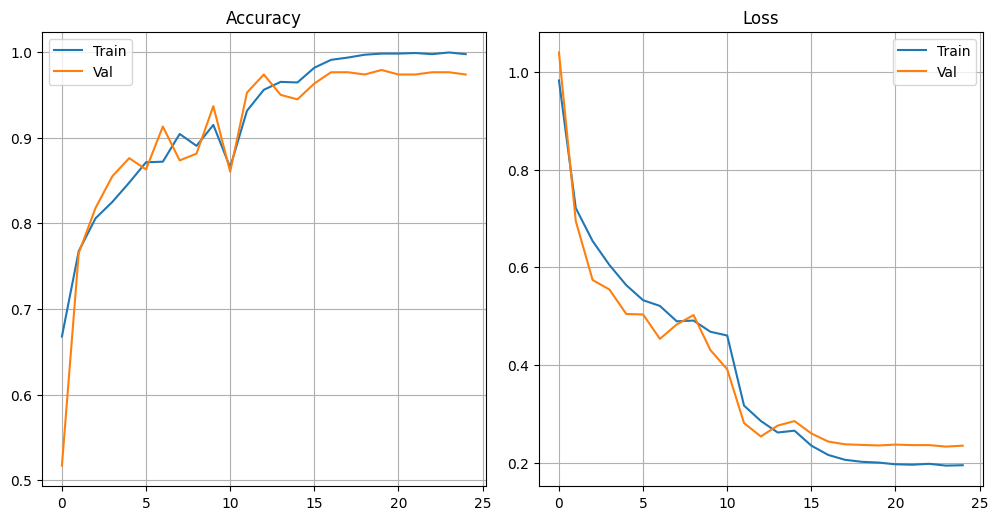

12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step

Classification Report:

              precision    recall  f1-score   support

      Class0       0.98      0.95      0.97       127
      Class1       1.00      1.00      1.00       126
      Class2       0.95      0.98      0.97       126

    accuracy                           0.98       379
   macro avg       0.98      0.98      0.98       379
weighted avg       0.98      0.98      0.98       379



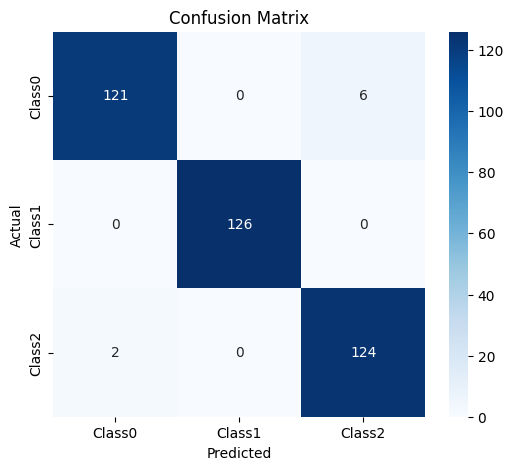

In [ ]:
print("History1 keys:", history1.history.keys())
print("History2 keys:", history2.history.keys())

# ========= 8. EVALUATION =========

def merge_histories(h1, h2):
    # Merge only common keys to avoid KeyError
    common_keys = set(h1.history.keys()).intersection(h2.history.keys())
    return {k: h1.history[k] + h2.history[k] for k in common_keys}

def plot_metrics(history):
    metrics = ['accuracy', 'loss']
    for metric in ['auc_2', 'precision_2', 'recall_2']:
        if metric in history:
            metrics.append(metric)

    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics):
        val_metric = 'val_' + metric
        if val_metric in history:
            plt.subplot(2, 3, i+1)
            plt.plot(history[metric], label='Train')
            plt.plot(history[val_metric], label='Val')
            plt.title(metric.replace('_', ' ').capitalize())
            plt.grid()
            plt.legend()
    plt.tight_layout()
    plt.show()

# Merge histories safely
history = merge_histories(history1, history2)

# Plot training metrics
plot_metrics(history)

# Reload best model weights
model.load_weights(checkpoint_path)

# ========= Evaluation Predictions =========
# ========= Evaluation Predictions =========

# No reset needed for custom Sequence generator
steps = len(val_gen)

# Predict
preds = model.predict(val_gen, steps=steps, verbose=1)
y_pred = np.argmax(preds, axis=1)

# Reconstruct true labels
y_true = np.argmax(np.vstack([val_gen[i][1] for i in range(len(val_gen))]), axis=1)

# Class names
class_names = ["Class0", "Class1", "Class2"]  # Replace with your actual class names if needed

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model_save_path = "/content/drive/MyDrive/cataract/final_cbam_densenet201_model_v5.h5"
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.densenet import preprocess_input

# ====== 1. Load model ======
model_path = "/content/drive/MyDrive/cataract/final_cbam_densenet201_model_v5.h5"
model = load_model(model_path, compile=False)
print("✅ Model loaded successfully!")

# ====== 2. Define class labels ======
cataract_classes = ['Mild_pupil_filter_img', 'Severe_pupil_filter_img', 'Normal_pupil_filter_img']

# ====== 3. Load and preprocess image ======
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (1024, 1024))                      # Resize to model input size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)             # Convert BGR to RGB
    img = preprocess_input(img)                            # Normalize like training
    img = np.expand_dims(img, axis=0)                      # Shape: (1, 224, 224, 3)
    return img

# ====== 4. Predict function ======
def predict_cataract(image_path):
    img = preprocess_image(image_path)
    preds = model.predict(img)[0]                          # Shape: (3,)
    class_idx = np.argmax(preds)
    class_label = cataract_classes[class_idx]
    confidence = preds[class_idx] * 100

    print(f"🔍 Prediction Probabilities: {preds}")
    print(f"✅ Predicted class: {class_label} ({confidence:.2f}%)")

# ====== 5. Run prediction ======
# Replace with your image path
test_image_path = "/content/IMG_0285 (1)_pupil.jpg"
predict_cataract(test_image_path)


✅ Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
🔍 Prediction Probabilities: [6.5005414e-02 9.3417150e-01 8.2310365e-04]
✅ Predicted class: Severe_pupil_filter_img (93.42%)


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_cataract(img_path, model, class_names):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_array)
    class_index = np.argmax(pred)
    class_label = class_names[class_index]
    confidence = np.max(pred)

    # Display result
    print(f"✅ Predicted Class: {class_label} (Confidence: {confidence:.2f})")
    return class_label, confidence

In [ ]:
def load_dataset(path):
    image_paths, labels = [], []
    class_names = sorted(os.listdir(path))
    class_to_idx = {cls: i for i, cls in enumerate(class_names)}  # ✅ store this

    for cls in class_names:
        cls_dir = os.path.join(path, cls)
        for img_name in os.listdir(cls_dir):
            image_paths.append(os.path.join(cls_dir, img_name))
            one_hot = tf.keras.utils.to_categorical(class_to_idx[cls], NUM_CLASSES)
            labels.append(one_hot)

    return np.array(image_paths), np.array(labels), class_names, class_to_idx
image_paths, labels, class_names, class_to_idx = load_dataset(DATA_DIR)
print(class_to_idx)

{'Mild_pupil': 0, 'Normal_pupil': 1, 'Severe_pupil': 2}


In [ ]:
def grad_cam(img_path, model, class_names, last_conv_layer_name="conv5_block32_concat"):
    """
    Generate and display Grad-CAM heatmap for an input image.

    Args:
      img_path (str): Path to the input image.
      model (tf.keras.Model): Trained Keras model.
      class_names (list): List of class names.
      last_conv_layer_name (str): Name of the last convolutional layer to use for Grad-CAM.
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Create a model that maps the input image to the activations
    # of the last conv layer and the output predictions
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients of the target class output value with respect to
    # the output feature map of the last conv layer
    grads = tape.gradient(class_channel, conv_outputs)

    # Pool the gradients over all axes except for the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is"
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    heatmap = heatmap.numpy()

    # Resize heatmap to original image size
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)

    # Apply colormap to heatmap
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Load original image for overlay
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    original_img = cv2.resize(original_img, (224, 224))

    # Superimpose the heatmap on original image
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_color, 0.4, 0)

    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM: {class_names[pred_index.numpy()]}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
✅ Predicted Class: Mild_pupil (Confidence: 0.95)


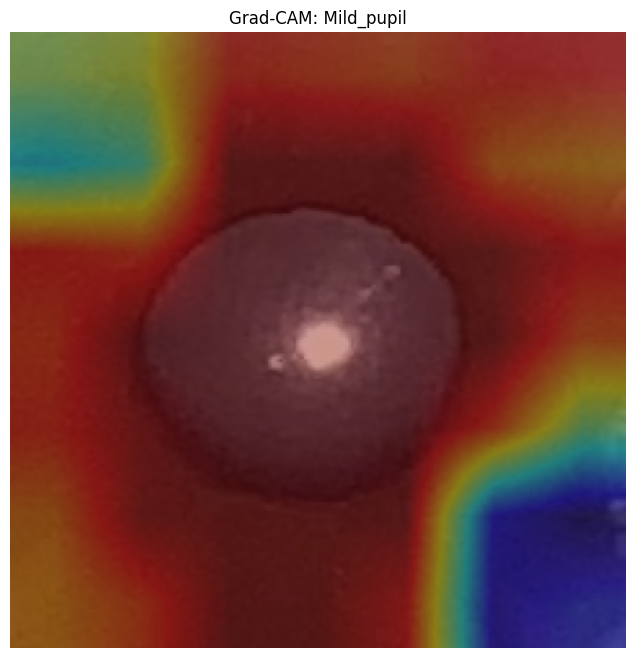

In [ ]:
 predict_cataract("/content/drive/MyDrive/cataract/dataset/Mild_pupil/8_7.jpg", model, class_names)
 grad_cam("/content/drive/MyDrive/cataract/dataset/Mild_pupil/8_7.jpg", model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
✅ Predicted Class: Severeretina (Confidence: 0.92)


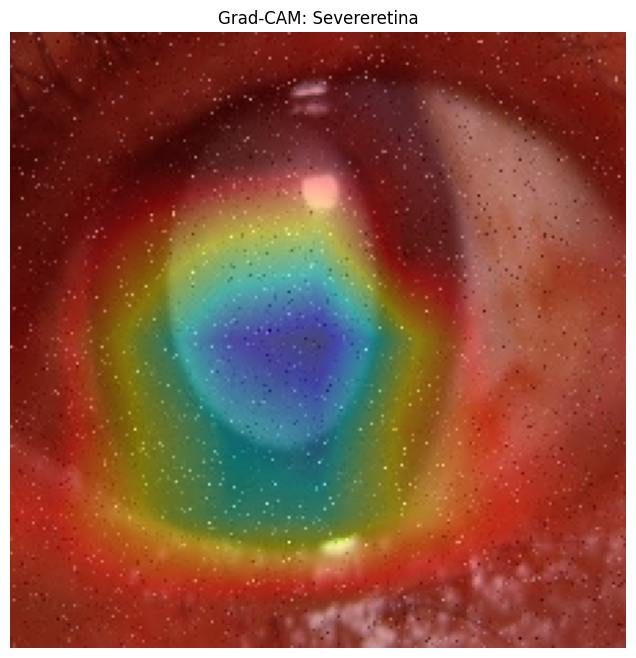

In [ ]:
 predict_cataract("/content/drive/MyDrive/cataract/dataset_v2/Severeretina/1_JPG_jpg.rf.c47190cce3a7c06de1fc36c4a05b5533.jpg", model, class_names)
 grad_cam("/content/drive/MyDrive/cataract/dataset_v2/Severeretina/1_JPG_jpg.rf.c47190cce3a7c06de1fc36c4a05b5533.jpg", model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
✅ Predicted Class: Normalretina (Confidence: 0.89)


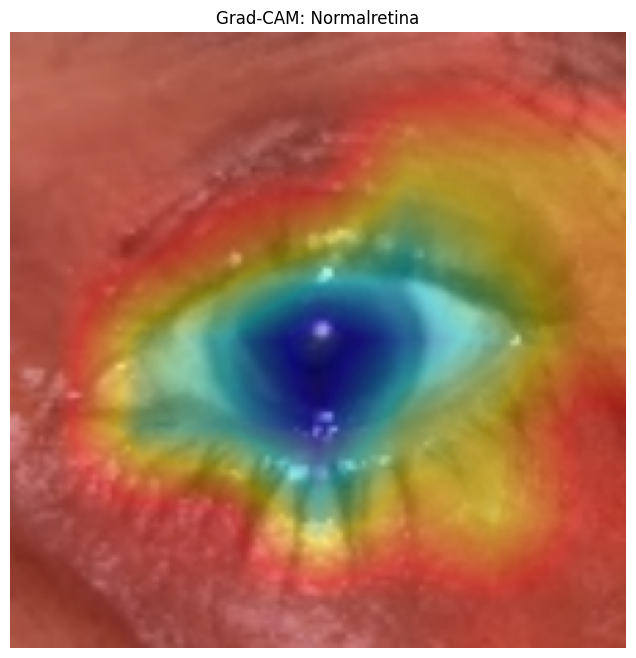

In [ ]:
 predict_cataract("/content/drive/MyDrive/cataract/dataset_v2/Normalretina/IMG_1255_eye0.jpg", model, class_names)
 grad_cam("/content/drive/MyDrive/cataract/dataset_v2/Normalretina/IMG_1255_eye0.jpg", model, class_names)

In [ ]:
pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
# ========= CLEANED & COMPLETE CATARACT CBAM MODEL =========
import os
import numpy as np
import cv2
import tensorflow as tf
import albumentations as A
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

# ========= CONFIG =========
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS_PHASE1 = 10
EPOCHS_PHASE2 = 25
NUM_CLASSES = 3
DATA_DIR = "/content/drive/MyDrive/cataract/dataset_v2"
checkpoint_path = "best_cbam_model.h5"

# ========= CBAM BLOCK =========
def cbam_block(input_tensor, ratio=8):
    channel = input_tensor.shape[-1]
    shared_dense_1 = Dense(channel // ratio, activation='relu')
    shared_dense_2 = Dense(channel)

    avg_pool = GlobalAveragePooling2D()(input_tensor)
    max_pool = GlobalMaxPooling2D()(input_tensor)

    avg_out = shared_dense_2(shared_dense_1(avg_pool))
    max_out = shared_dense_2(shared_dense_1(max_pool))

    channel_attention = Activation('sigmoid')(Add()([avg_out, max_out]))
    channel_attention = Reshape((1, 1, channel))(channel_attention)
    x = Multiply()([input_tensor, channel_attention])

    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)

    return Multiply()([x, spatial_attention])

# ========= AUGMENTATION =========
transform = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomBrightnessContrast(),
    A.GaussianBlur(p=0.2),
    A.Rotate(limit=20),
    A.RandomGamma(),
    A.Normalize(),
])

val_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize()
])

# ========= DATA GENERATOR =========
class CustomDataset(Sequence):
    def __init__(self, image_paths, labels, augment, batch_size=BATCH_SIZE, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.augment = augment
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)


def __getitem__(self, index):
    batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
    batch_images = np.zeros((self.batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((self.batch_size, NUM_CLASSES), dtype=np.float32)

    for i, idx in enumerate(batch_indices):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        augmented = self.augment(image=img)
        img_aug = augmented['image']

        # ✅ Ensure shape is (224, 224, 3)
        if img_aug.shape[:2] != (224, 224):
            img_aug = cv2.resize(img_aug, (224, 224))

        # ✅ Ensure dtype is float32
        if img_aug.dtype != np.float32:
            img_aug = img_aug.astype(np.float32)

        batch_images[i] = img_aug
        batch_labels[i] = label

    return batch_images, batch_labels


# ========= LOAD DATA =========
def load_dataset(path):
    image_paths, labels = [], []
    class_names = sorted(os.listdir(path))
    class_to_idx = {cls: i for i, cls in enumerate(class_names)}
    for cls in class_names:
        cls_dir = os.path.join(path, cls)
        for img_name in os.listdir(cls_dir):
            image_paths.append(os.path.join(cls_dir, img_name))
            one_hot = tf.keras.utils.to_categorical(class_to_idx[cls], NUM_CLASSES)
            labels.append(one_hot)
    return np.array(image_paths), np.array(labels), class_names

image_paths, labels, class_names = load_dataset(DATA_DIR)
trainX, valX, trainY, valY = train_test_split(image_paths, labels, test_size=0.2, stratify=labels.argmax(1))

train_gen = CustomDataset(trainX, trainY, transform)
val_gen = CustomDataset(valX, valY, val_transform, shuffle=False)

# ========= CLASS WEIGHTS =========
weights = compute_class_weight('balanced', classes=np.unique(trainY.argmax(1)), y=trainY.argmax(1))
class_weights = dict(enumerate(weights))

# ========= MODEL =========
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = DenseNet201(include_top=False, weights='imagenet', input_tensor=input_tensor)

x = base_model.output
x = cbam_block(x)

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)

# ========= TRAINING =========
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(1e-3, first_decay_steps=10)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Phase 1
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history1 = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS_PHASE1,
                     class_weight=class_weights, callbacks=callbacks)

# Phase 2
for layer in base_model.layers[:250]:
    layer.trainable = False
for layer in base_model.layers[250:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history2 = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS_PHASE2,
                     class_weight=class_weights, callbacks=callbacks)

# ========= PLOT HISTORY =========
def merge_histories(h1, h2):
    merged = {}
    for k in h1.history:
        merged[k] = h1.history[k] + h2.history[k]
    return merged

def plot_metrics(history):
    metrics = ['accuracy', 'loss', 'auc', 'precision', 'recall']
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        plt.plot(history[metric], label='Train')
        plt.plot(history['val_' + metric], label='Val')
        plt.title(metric.upper())
        plt.grid()
        plt.legend()
    plt.tight_layout()
    plt.show()

history = merge_histories(history1, history2)
plot_metrics(history)

# ========= EVALUATION =========
model.load_weights(checkpoint_path)
val_preds = model.predict(val_gen)
y_true = np.argmax(valY, axis=1)
y_pred = np.argmax(val_preds, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


NotImplementedError: 

In [ ]:
# ========= 1. IMPORTS =========
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, GlobalAveragePooling2D,
                                     Conv2D, Multiply, Add, Reshape, Concatenate, Activation,
                                     BatchNormalization, GlobalMaxPooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import cv2

# ========= 2. CUSTOM LAYERS FOR REDUCE MEAN/MAX =========
from tensorflow.keras.layers import Layer

class ReduceMeanLayer(Layer):
    def __init__(self, axis, keepdims=True, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis
        self.keepdims = keepdims

    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=self.axis, keepdims=self.keepdims)

    def compute_output_shape(self, input_shape):
        input_shape = list(input_shape)
        if self.keepdims:
            input_shape[self.axis] = 1
            return tuple(input_shape)
        else:
            del input_shape[self.axis]
            return tuple(input_shape)

class ReduceMaxLayer(Layer):
    def __init__(self, axis, keepdims=True, **kwargs):
        super(ReduceMaxLayer, self).__init__(**kwargs)
        self.axis = axis
        self.keepdims = keepdims

    def call(self, inputs):
        return tf.reduce_max(inputs, axis=self.axis, keepdims=self.keepdims)

    def compute_output_shape(self, input_shape):
        input_shape = list(input_shape)
        if self.keepdims:
            input_shape[self.axis] = 1
            return tuple(input_shape)
        else:
            del input_shape[self.axis]
            return tuple(input_shape)

def cbam_block(input_tensor, ratio=8):
    channel_avg = GlobalAveragePooling2D()(input_tensor)
    channel_max = GlobalMaxPooling2D()(input_tensor)

    shared_dense_1 = Dense(input_tensor.shape[-1] // ratio, activation='relu')
    shared_dense_2 = Dense(input_tensor.shape[-1])

    avg_out = shared_dense_2(shared_dense_1(channel_avg))
    max_out = shared_dense_2(shared_dense_1(channel_max))

    channel_attention = Activation('sigmoid')(Add()([avg_out, max_out]))
    channel_attention = Reshape((1, 1, input_tensor.shape[-1]))(channel_attention)
    channel_refined = Multiply()([input_tensor, channel_attention])

    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True),
                      output_shape=lambda input_shape: input_shape[:-1] + (1,))(channel_refined)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True),
                      output_shape=lambda input_shape: input_shape[:-1] + (1,))(channel_refined)

    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_attention = Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    spatial_refined = Multiply()([channel_refined, spatial_attention])

    return spatial_refined

class SimpleGen(Sequence):
    def __init__(self, x, y, batch_size=32, augment=False):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.x[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]

        if self.augment:
            batch_x = np.array([self.augment_image(img) for img in batch_x])
        batch_x = batch_x / 255.0
        return batch_x, batch_y

    def augment_image(self, img):
        img = tf.convert_to_tensor(img)
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        return img.numpy()

# ========= 6. CONFIG =========
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS_PHASE1 = 10
EPOCHS_PHASE2 = 15
NUM_CLASSES = 3
DATA_DIR = "/content/drive/MyDrive/cataract/dataset_v2"  # Change to your path

# ========= 7. LOAD DATA =========
X, y, class_names = load_images_and_labels(DATA_DIR, IMAGE_SIZE)
X_flat = X.reshape(len(X), -1)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_flat, y)
X_resampled = X_resampled.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
y_resampled = to_categorical(y_resampled, num_classes=NUM_CLASSES)

X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

train_gen = SimpleGen(X_train, y_train, batch_size=BATCH_SIZE, augment=True)
val_gen = SimpleGen(X_val, y_val, batch_size=BATCH_SIZE, augment=False)

# ========= 8. MODEL BUILD =========
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = DenseNet201(include_top=False, weights='imagenet', input_tensor=input_tensor)

x = base_model.output
x = cbam_block(x)
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)

# ========= 9. COMPILE & CALLBACKS =========
checkpoint_path = "best_cbam_smote_model.h5"
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
]

# ========= 10. TRAINING PHASE 1 (head only) =========
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-3),
              loss=CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

print("\n🔁 Phase 1: Train head only")
history1 = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS_PHASE1, callbacks=callbacks)

# ========= 11. TRAINING PHASE 2 (fine-tune) =========
for layer in base_model.layers[:250]:
    layer.trainable = False
for layer in base_model.layers[250:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-4),
              loss=CategoricalCrossentropy(label_smoothing=0.05),
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

print("\n🔁 Phase 2: Fine-tuning")
history2 = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS_PHASE2, callbacks=callbacks)



🔁 Phase 1: Train head only


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5666 - auc_2: 0.7369 - loss: 1.2129 - precision_2: 0.5783 - recall_2: 0.5270
Epoch 1: val_accuracy improved from -inf to 0.61364, saving model to best_cbam_smote_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.5693 - auc_2: 0.7398 - loss: 1.2067 - precision_2: 0.5812 - recall_2: 0.5300 - val_accuracy: 0.6136 - val_auc_2: 0.8410 - val_loss: 0.8452 - val_precision_2: 0.6813 - val_recall_2: 0.5636 - learning_rate: 0.0010
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.7658 - auc_2: 0.9189 - loss: 0.7468 - precision_2: 0.8054 - recall_2: 0.7385
Epoch 2: val_accuracy improved from 0.61364 to 0.64091, saving model to best_cbam_smote_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 401ms/step - accuracy: 0.7668 - auc_2: 0.9193 - loss: 0.7457 - precision_2: 0.8060 - recall_2: 0.7395 - val_accuracy: 0.6409 - val_auc_2: 0.8351 - val_loss: 0.8615 - val_precision_2: 0.6526 - val_recall_2: 0.5636 - learning_rate: 0.0010
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8129 - auc_2: 0.9352 - loss: 0.7059 - precision_2: 0.8263 - recall_2: 0.7928
Epoch 3: val_accuracy improved from 0.64091 to 0.76818, saving model to best_cbam_smote_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 406ms/step - accuracy: 0.8129 - auc_2: 0.9354 - loss: 0.7050 - precision_2: 0.8266 - recall_2: 0.7927 - val_accuracy: 0.7682 - val_auc_2: 0.9121 - val_loss: 0.7065 - val_precision_2: 0.8212 - val_recall_2: 0.6682 - learning_rate: 0.0010
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.7944 - auc_2: 0.9367 - loss: 0.6765 - precision_2: 0.8198 - recall_2: 0.7561
Epoch 4: val_accuracy improved from 0.76818 to 0.84545, saving model to best_cbam_smote_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 409ms/step - accuracy: 0.7956 - auc_2: 0.9371 - loss: 0.6751 - precision_2: 0.8209 - recall_2: 0.7573 - val_accuracy: 0.8455 - val_auc_2: 0.9576 - val_loss: 0.5839 - val_precision_2: 0.9162 - val_recall_2: 0.7955 - learning_rate: 0.0010
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.8412 - auc_2: 0.9612 - loss: 0.6000 - precision_2: 0.8632 - recall_2: 0.8248
Epoch 5: val_accuracy did not improve from 0.84545
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step - accuracy: 0.8412 - auc_2: 0.9608 - loss: 0.6012 - precision_2: 0.8630 - recall_2: 0.8246 - val_accuracy: 0.8455 - val_auc_2: 0.9624 - val_loss: 0.5714 - val_precision_2: 0.8612 - val_recall_2: 0.8182 - learning_rate: 0.0010
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8615 - auc_2: 0.9636 - loss: 0.5755 - precision_2: 0.8813 - recall_2: 0.8445
Epoch 6: val_accuracy improved from 0.84545 to 0.87727, saving model to best_cbam_smote_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 401ms/step - accuracy: 0.8617 - auc_2: 0.9637 - loss: 0.5750 - precision_2: 0.8816 - recall_2: 0.8446 - val_accuracy: 0.8773 - val_auc_2: 0.9655 - val_loss: 0.5659 - val_precision_2: 0.8852 - val_recall_2: 0.8409 - learning_rate: 0.0010
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8955 - auc_2: 0.9791 - loss: 0.5098 - precision_2: 0.9222 - recall_2: 0.8795
Epoch 7: val_accuracy did not improve from 0.87727
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 358ms/step - accuracy: 0.8949 - auc_2: 0.9789 - loss: 0.5109 - precision_2: 0.9215 - recall_2: 0.8790 - val_accuracy: 0.8591 - val_auc_2: 0.9668 - val_loss: 0.5464 - val_precision_2: 0.8852 - val_recall_2: 0.8409 - learning_rate: 0.0010
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9118 - auc_2: 0.9788 - loss: 0.5069 - precision_2: 0.9245 - recall_2: 0.8878
Epoch 8: val_accuracy did not improve from 0.87727
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 360ms/step - accuracy: 0.9117 - auc_2: 0.9787

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 729ms/step - accuracy: 0.9087 - auc_3: 0.9860 - loss: 0.3669 - precision_3: 0.9321 - recall_3: 0.8974 - val_accuracy: 0.8818 - val_auc_3: 0.9797 - val_loss: 0.4283 - val_precision_3: 0.9009 - val_recall_3: 0.8682 - learning_rate: 1.0000e-04
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9605 - auc_3: 0.9951 - loss: 0.2925 - precision_3: 0.9663 - recall_3: 0.9588
Epoch 3: val_accuracy improved from 0.88182 to 0.89545, saving model to best_cbam_smote_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 663ms/step - accuracy: 0.9606 - auc_3: 0.9951 - loss: 0.2922 - precision_3: 0.9664 - recall_3: 0.9588 - val_accuracy: 0.8955 - val_auc_3: 0.9806 - val_loss: 0.4158 - val_precision_3: 0.9112 - val_recall_3: 0.8864 - learning_rate: 1.0000e-04
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9783 - auc_3: 0.9988 - loss: 0.2514 - precision_3: 0.9848 - recall_3: 0.9729
Epoch 4: val_accuracy improved from 0.89545 to 0.91364, saving model to best_cbam_smote_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 723ms/step - accuracy: 0.9783 - auc_3: 0.9988 - loss: 0.2513 - precision_3: 0.9847 - recall_3: 0.9729 - val_accuracy: 0.9136 - val_auc_3: 0.9857 - val_loss: 0.3689 - val_precision_3: 0.9256 - val_recall_3: 0.9045 - learning_rate: 1.0000e-04
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9688 - auc_3: 0.9978 - loss: 0.2584 - precision_3: 0.9788 - recall_3: 0.9633
Epoch 5: val_accuracy improved from 0.91364 to 0.92273, saving model to best_cbam_smote_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 729ms/step - accuracy: 0.9693 - auc_3: 0.9978 - loss: 0.2576 - precision_3: 0.9792 - recall_3: 0.9640 - val_accuracy: 0.9227 - val_auc_3: 0.9883 - val_loss: 0.3752 - val_precision_3: 0.9224 - val_recall_3: 0.9182 - learning_rate: 1.0000e-04
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9944 - auc_3: 0.9997 - loss: 0.2219 - precision_3: 0.9944 - recall_3: 0.9938
Epoch 6: val_accuracy did not improve from 0.92273
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 500ms/step - accuracy: 0.9944 - auc_3: 0.9997 - loss: 0.2219 - precision_3: 0.9944 - recall_3: 0.9938 - val_accuracy: 0.9227 - val_auc_3: 0.9871 - val_loss: 0.3635 - val_precision_3: 0.9224 - val_recall_3: 0.9182 - learning_rate: 1.0000e-04
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9945 - auc_3: 0.9999 - loss: 0.2130 - precision_3: 0.9960 - recall_3: 0.9931
Epoch 7: val_accuracy improved from 0.92273 to 0.92727, saving model to best_cbam_smote_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 679ms/step - accuracy: 0.9944 - auc_3: 0.9999 - loss: 0.2133 - precision_3: 0.9959 - recall_3: 0.9931 - val_accuracy: 0.9273 - val_auc_3: 0.9879 - val_loss: 0.3563 - val_precision_3: 0.9352 - val_recall_3: 0.9182 - learning_rate: 1.0000e-04
Epoch 8/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.9943 - auc_3: 0.9995 - loss: 0.2181 - precision_3: 0.9943 - recall_3: 0.9891
Epoch 8: val_accuracy did not improve from 0.92727
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 494ms/step - accuracy: 0.9943 - auc_3: 0.9995 - loss: 0.2181 - precision_3: 0.9943 - recall_3: 0.9892 - val_accuracy: 0.9136 - val_auc_3: 0.9883 - val_loss: 0.3776 - val_precision_3: 0.9178 - val_recall_3: 0.9136 - learning_rate: 1.0000e-04
Epoch 9/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9983 - auc_3: 1.0000 - loss: 0.2129 - precision_3: 0.9983 - recall_3: 0.9983
Epoch 9: val_accuracy did not improve from 0.92727
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 495ms/step - accuracy: 0.9984 - auc_3

In [ ]:
model_save_path = "/content/drive/MyDrive/cataract/final_cbam_densenet201_model_v2.h5"
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/MyDrive/cataract/final_cbam_densenet201_model_v2.h5


In [ ]:
 # mount google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


coco json to labels

In [ ]:
import json
import os
from collections import defaultdict

# === Set your paths ===
coco_json_path = "/content/drive/MyDrive/cataract/cocojson/eyelash/labels_my-project-name_2025-07-17-12-23-24.json"
output_labels_dir = "/content/drive/MyDrive/cataract/eyelash_dataset/labels"
image_folder = "/content/drive/MyDrive/cataract/eyelash_dataset"

# === Create output directory ===
os.makedirs(output_labels_dir, exist_ok=True)

# === Load COCO JSON ===
with open(coco_json_path, 'r') as f:
    coco = json.load(f)

# === Dictionaries for fast access ===
image_id_to_filename = {img["id"]: img["file_name"] for img in coco["images"]}
image_id_to_size = {img["id"]: (img["width"], img["height"]) for img in coco["images"]}
category_id_to_index = {cat["id"]: i for i, cat in enumerate(coco["categories"])}

# === Group annotations by image_id ===
annotations_by_image = defaultdict(list)
for ann in coco["annotations"]:
    annotations_by_image[ann["image_id"]].append(ann)

# === Generate YOLO labels ===
for image_id, annotations in annotations_by_image.items():
    filename = image_id_to_filename[image_id]
    width, height = image_id_to_size[image_id]
    label_lines = []

    for ann in annotations:
        category_id = ann["category_id"]
        class_index = category_id_to_index[category_id]

        # COCO bbox: x_min, y_min, width, height
        x, y, w, h = ann["bbox"]
        x_center = (x + w / 2) / width
        y_center = (y + h / 2) / height
        w /= width
        h /= height

        label_line = f"{class_index} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}"
        label_lines.append(label_line)

    # ✅ Match image filename exactly, just replace extension
    txt_filename = os.path.basename(filename)
    txt_filename = os.path.splitext(txt_filename)[0] + ".txt"
    txt_path = os.path.join(output_labels_dir, txt_filename)

    with open(txt_path, 'w') as f:
        f.write('\n'.join(label_lines))

print("✅ Conversion complete! YOLO labels saved to:", output_labels_dir)



✅ Conversion complete! YOLO labels saved to: /content/drive/MyDrive/cataract/eyelash_dataset/labels


In [ ]:
import os
import json
import cv2

# Paths
coco_json_path = "/content/drive/MyDrive/cataract/cocojson/eyelash/labels_my-project-name_2025-07-13-05-12-43.json"
images_dir =  "/content/drive/MyDrive/cataract/eyelash_dataset"
output_dir = "/content/drive/MyDrive/cataract/eyelash_dataset_v2"
os.makedirs(output_dir, exist_ok=True)

# Load COCO annotations
with open(coco_json_path, "r") as f:
    coco = json.load(f)

# Mapping from image ID to file name
id_to_filename = {img["id"]: img["file_name"] for img in coco["images"]}
filename_to_id = {v: k for k, v in id_to_filename.items()}

# Group annotations by image_id
from collections import defaultdict
annotations_by_id = defaultdict(list)
for ann in coco["annotations"]:
    annotations_by_id[ann["image_id"]].append(ann)

# Load Haar cascade (fallback)
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Supported extensions
image_extensions = ('.jpg', '.jpeg', '.png')

# Start processing
for img_name in os.listdir(images_dir):
    if not img_name.lower().endswith(image_extensions):
        continue

    img_path = os.path.join(images_dir, img_name)
    img = cv2.imread(img_path)
    if img is None:
        print("Could not read:", img_path)
        continue

    image_id = filename_to_id.get(img_name)

    if image_id in annotations_by_id:
        # Crop using COCO bbox
        for ann in annotations_by_id[image_id]:
            x, y, w, h = map(int, ann["bbox"])
            cropped = img[y:y+h, x:x+w]
            out_name = f"{os.path.splitext(img_name)[0]}_coco_{ann['id']}.jpg"
            cv2.imwrite(os.path.join(output_dir, out_name), cropped)
    else:
        # Fallback: Haar cascade eye detection
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        if len(eyes) > 0:
            for i, (x, y, w, h) in enumerate(eyes[:1]):  # First detection
                cropped = img[y:y+h, x:x+w]
                out_name = f"{os.path.splitext(img_name)[0]}_haar.jpg"
                cv2.imwrite(os.path.join(output_dir, out_name), cropped)
        else:
            # Optional: fallback center crop (e.g., 100x100 in center)
            h_img, w_img = img.shape[:2]
            cx, cy = w_img // 2, h_img // 2
            size = 100
            cropped = img[cy-size//2:cy+size//2, cx-size//2:cx+size//2]
            out_name = f"{os.path.splitext(img_name)[0]}_center.jpg"
            cv2.imwrite(os.path.join(output_dir, out_name), cropped)

print("✅ Done: All 439 images processed with COCO, Haar or center fallback.")

✅ Done: All 439 images processed with COCO, Haar or center fallback.


In [ ]:
import os
import shutil
import random

# === Set seed for reproducibility ===
random.seed(42)

# === Source paths ===
image_source = '/content/drive/MyDrive/cataract/eyelash_dataset'
label_source = '/content/drive/MyDrive/cataract/eyelash_dataset/labels'

# === Destination paths ===
train_image_folder = '/content/drive/MyDrive/cataract/eyelash/images/train'
val_image_folder   = '/content/drive/MyDrive/cataract/eyelash/images/val'
train_label_folder = '/content/drive/MyDrive/cataract/eyelash/labels/train'
val_label_folder   = '/content/drive/MyDrive/cataract/eyelash/labels/val'

# === Create folders ===
os.makedirs(train_image_folder, exist_ok=True)
os.makedirs(val_image_folder, exist_ok=True)
os.makedirs(train_label_folder, exist_ok=True)
os.makedirs(val_label_folder, exist_ok=True)

# === Get image files ===
all_images = [f for f in os.listdir(image_source) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
random.shuffle(all_images)

# === Split into train/val ===
split_idx = int(0.8 * len(all_images))
train_files = all_images[:split_idx]
val_files = all_images[split_idx:]

# === Helper to copy image + label ===
def copy_image_and_label(file_list, img_dest, label_dest):
    for img_name in file_list:
        base = os.path.splitext(img_name)[0]
        label_name = base + ".txt"

        # Source paths
        src_img_path = os.path.join(image_source, img_name)
        src_label_path = os.path.join(label_source, label_name)

        # Destination paths
        dst_img_path = os.path.join(img_dest, img_name)
        dst_label_path = os.path.join(label_dest, label_name)

        # Copy image
        shutil.copy(src_img_path, dst_img_path)

        # Copy label if exists
        if os.path.exists(src_label_path):
            shutil.copy(src_label_path, dst_label_path)
        else:
            print(f"⚠️ Label missing for image: {img_name}")

# === Copy files ===
copy_image_and_label(train_files, train_image_folder, train_label_folder)
copy_image_and_label(val_files, val_image_folder, val_label_folder)

print(f"✅ Done: {len(train_files)} train and {len(val_files)} val images + labels copied.")




✅ Done: 20 train and 5 val images + labels copied.


In [ ]:
pip install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:

!pip install ultralytics
from ultralytics import YOLO

# Load a YOLOv8n model (fast & light). Use 'yolov8s' or 'yolov8m' for better accuracy.
model = YOLO('yolov8n.yaml')  # or yolov8s.yaml

# Train the model
model.train(
    data='/content/drive/MyDrive/cataract/pupil_detection/data.yaml',
    epochs=12,
    imgsz=640,
    batch=16,
    name='yolov8_pupil',
    project='/content/drive/MyDrive/cataract/yolo_output'
)



Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/cataract/pupil_detection/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=12, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_pupil5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective

train: Scanning /content/drive/MyDrive/cataract/pupil_detection/labels/train... 504 images, 0 backgrounds, 0 corrupt: 100%|██████████| 504/504 [00:27<00:00, 18.11it/s]


train: New cache created: /content/drive/MyDrive/cataract/pupil_detection/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 2.2±2.0 ms, read: 91.6±109.2 MB/s, size: 7759.5 KB)


val: Scanning /content/drive/MyDrive/cataract/pupil_detection/labels/val... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:09<00:00, 13.36it/s]


val: New cache created: /content/drive/MyDrive/cataract/pupil_detection/labels/val.cache
Plotting labels to /content/drive/MyDrive/cataract/yolo_output/yolov8_pupil5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/cataract/yolo_output/yolov8_pupil5
Starting training for 12 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/12      2.09G      3.622      4.556      4.141          9        640: 100%|██████████| 32/32 [02:55<00:00,  5.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        127        127   0.000999      0.291    0.00137   0.000318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/12      2.57G       2.98       3.78      3.593         14        640: 100%|██████████| 32/32 [02:49<00:00,  5.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        127        127   0.000974      0.291    0.00152   0.000681


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/12      2.59G      2.088      3.304      2.904          8        640: 100%|██████████| 32/32 [02:59<00:00,  5.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        127        127     0.0367      0.063    0.00918    0.00267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/12      2.61G      1.755      2.394      2.402          8        640: 100%|██████████| 32/32 [02:45<00:00,  5.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        127        127      0.269       0.11     0.0704     0.0237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/12      2.62G      1.564      1.981      2.119          8        640: 100%|██████████| 32/32 [02:37<00:00,  4.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        127        127      0.555      0.677      0.576      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/12      2.64G      1.432      1.613      1.956          8        640: 100%|██████████| 32/32 [02:39<00:00,  5.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        127        127      0.775      0.953      0.929      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/12      2.66G      1.347      1.386      1.829          8        640: 100%|██████████| 32/32 [02:47<00:00,  5.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        127        127      0.975      0.909      0.986      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/12      2.67G      1.313      1.252      1.758          8        640: 100%|██████████| 32/32 [02:43<00:00,  5.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        127        127      0.932      0.976      0.987      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/12      2.69G      1.249      1.154      1.722          8        640: 100%|██████████| 32/32 [02:48<00:00,  5.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

                   all        127        127      0.953      0.959      0.991      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/12      2.71G      1.201      1.065      1.652          8        640: 100%|██████████| 32/32 [02:46<00:00,  5.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        127        127      0.919      0.969      0.988      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/12      2.73G      1.175      1.006      1.618          8        640: 100%|██████████| 32/32 [02:47<00:00,  5.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        127        127       0.94      0.983      0.988      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/12      2.74G      1.161     0.9471       1.61          8        640: 100%|██████████| 32/32 [02:46<00:00,  5.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

                   all        127        127      0.947      0.992      0.992      0.707



12 epochs completed in 0.573 hours.
Optimizer stripped from /content/drive/MyDrive/cataract/yolo_output/yolov8_pupil5/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/cataract/yolo_output/yolov8_pupil5/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/cataract/yolo_output/yolov8_pupil5/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:57<00:00, 14.42s/it]


                   all        127        127      0.947      0.992      0.992      0.707
Speed: 0.3ms preprocess, 2.8ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/drive/MyDrive/cataract/yolo_output/yolov8_pupil5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff0f5863910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Results returned: 1
Image 1 - Detected boxes: 1


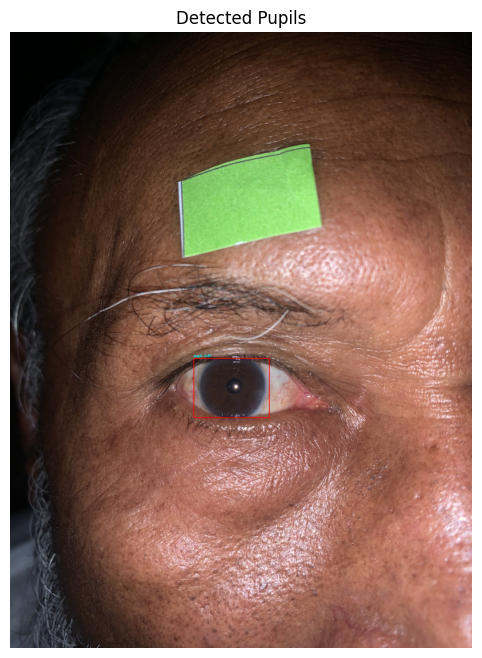

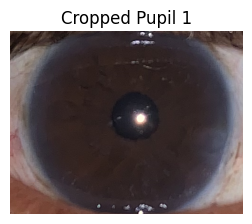

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os

# === Load trained YOLOv8 model ===
model = YOLO('/content/drive/MyDrive/cataract/yolo_output/yolov8_pupil5/weights/best.pt')

# === Input image ===
image_path = '/content/drive/MyDrive/cataract/Normal_converted/IMG_0284.png'
image = cv2.imread(image_path)
original_image = image.copy()
image_height, image_width = image.shape[:2]

# === Detect pupil(s) ===
results = model.predict(source=image_path, conf=0.1, verbose=False)
cropped_pupils = []

print(f"Results returned: {len(results)}")

for i, result in enumerate(results):
    print(f"Image {i+1} - Detected boxes: {len(result.boxes)}")
    for j, box in enumerate(result.boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())

        # Clamp to image bounds
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(image_width - 1, x2), min(image_height - 1, y2)

        # Draw box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 3)
        label = f"{model.names[int(box.cls)]}: {box.conf.item():.2f}"
        cv2.putText(image, label, (x1, max(y1 - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (255, 255, 0), 2)

        # Crop
        pupil_crop = original_image[y1:y2, x1:x2]
        cropped_pupils.append(pupil_crop)

# === Show full image with detections ===
plt.figure(figsize=(10, 8))
plt.title("Detected Pupils")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# === Show cropped pupil images ===
for i, crop in enumerate(cropped_pupils):
    plt.figure(figsize=(3, 3))
    plt.title(f'Cropped Pupil {i+1}')
    plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()



In [ ]:
import os

for root, dirs, files in os.walk("/"):
    for file in files:
        if file == "best.pt":
            print(os.path.join(root, file))

/content/drive/MyDrive/cataract/yolo_output/yolov8_pupil/weights/best.pt
/content/drive/MyDrive/cataract/yolo_output/yolov8_pupil2/weights/best.pt


In [ ]:
!find runs/detect -name best.pt

find: ‘runs/detect’: No such file or directory


Pupil Dataset create by using coco json

In [ ]:
import os
import json
import cv2
from tqdm import tqdm

# === CONFIGURATION ===
coco_json_path = '/content/drive/MyDrive/cataract/cocojson/Mild/labels_my-project-name_2025-07-12-08-56-27.json'         # Your COCO JSON file
image_folder = '/content/drive/MyDrive/cataract/Mild_converted/'                     # Folder with original images
output_folder = '/content/drive/MyDrive/cataract/dataset/Mild_pupil'            # Folder to save cropped pupils

os.makedirs(output_folder, exist_ok=True)

# === LOAD COCO JSON ===
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

# === CREATE IMAGE-ID TO FILENAME MAPPING ===
id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}

# === LOOP THROUGH ANNOTATIONS AND CROP ===
for ann in tqdm(coco_data['annotations']):
    image_id = ann['image_id']
    bbox = ann['bbox']  # [x, y, width, height]
    x, y, w, h = map(int, bbox)

    image_filename = id_to_filename[image_id]
    image_path = os.path.join(image_folder, image_filename)

    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        continue

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        continue

    crop = image[y:y+h, x:x+w]

    # Skip empty crops
    if crop.size == 0:
        print(f"Empty crop for: {image_filename}")
        continue

    # Save cropped image
    output_path = os.path.join(output_folder, f"{os.path.splitext(image_filename)[0]}_pupil.jpg")
    cv2.imwrite(output_path, crop)


  0%|          | 0/390 [00:00<?, ?it/s]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0499.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0500.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0504.png


  3%|▎         | 10/390 [00:21<18:23,  2.90s/it]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0518.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0522.png


  3%|▎         | 13/390 [00:23<10:59,  1.75s/it]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0523.png


  4%|▍         | 15/390 [00:26<09:56,  1.59s/it]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0524.png


  6%|▌         | 22/390 [00:41<14:03,  2.29s/it]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0533.png


  6%|▌         | 24/390 [00:43<10:59,  1.80s/it]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0534.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0536.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0541.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0542.png


  9%|▉         | 37/390 [01:04<11:50,  2.01s/it]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0586.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0587.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0588.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0589.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0617.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0619.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0620.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0621.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0624.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0627.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0628.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0629.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0630.png

 17%|█▋        | 68/390 [01:09<01:40,  3.20it/s]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0653.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0657.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0658.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0659.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0660.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0665.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0666.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0667.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0668.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0670 (1).png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0670 (2).png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0670 (3).png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/

 23%|██▎       | 88/390 [01:11<01:01,  4.94it/s]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0701.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0711.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0712.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0713.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0714.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0716.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0717.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0718.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0719.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0723.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0724.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0725.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_0726.png

 60%|██████    | 234/390 [05:02<06:18,  2.43s/it]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1324.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1325.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1326.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1327 (1).png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1327.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1345.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1346.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1347.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1348.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1364.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1365.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1375.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1376

 64%|██████▍   | 249/390 [05:05<01:11,  1.98it/s]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1410.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1411.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1412.png


 65%|██████▍   | 253/390 [05:08<01:10,  1.93it/s]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1437.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1460.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1461.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1462.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1463.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1503.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1517.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1536.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1537.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1538.png


 68%|██████▊   | 264/390 [05:11<00:49,  2.55it/s]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1558.png


 68%|██████▊   | 266/390 [05:13<01:02,  1.97it/s]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1560.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1563.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1586.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1587.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1588.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1589.png


 70%|███████   | 274/390 [05:17<01:01,  1.88it/s]

Failed to load image: /content/drive/MyDrive/cataract/Mild_converted/IMG_1601.png


 71%|███████   | 276/390 [05:22<01:40,  1.13it/s]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1608.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1613.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1621.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1626.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1627.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1628.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1629.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1631.png


 73%|███████▎  | 286/390 [05:26<01:01,  1.68it/s]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1636.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1637.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1638.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1640.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1641.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1642.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1643.png


 75%|███████▌  | 294/390 [05:28<00:42,  2.24it/s]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1684.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1685.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1686.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1687.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1688.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1694.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1726.png


100%|██████████| 390/390 [05:30<00:00,  1.18it/s]

Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1792.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1793.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1800.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1801.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1806.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1807.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1808.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1809.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1815.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1816.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1817.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1818.png
Image not found: /content/drive/MyDrive/cataract/Mild_converted/IMG_1819.png

eyelash remove


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# === PATH CONFIGURATION ===
input_folder = '/content/drive/MyDrive/cataract/dataset/severe_pupil'            # Folder with cropped pupil images
output_folder = '/content/drive/MyDrive/cataract/dataset/severe_pupil_fresh'         # Where to save the cleaned images

os.makedirs(output_folder, exist_ok=True)

# === FUNCTION: Remove Eyelash (Dark Area Inpainting) ===
def suppress_eyelash(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, dark_mask = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY_INV)
    inpainted = cv2.inpaint(image, dark_mask, 3, cv2.INPAINT_TELEA)
    return inpainted

# === FUNCTION: Apply CLAHE ===
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return enhanced

# === LOOP THROUGH IMAGES AND PROCESS ===
for filename in tqdm(os.listdir(input_folder)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(input_folder, filename)
        image = cv2.imread(img_path)

        if image is None:
            print(f"Skipped (cannot read): {filename}")
            continue

        # Step 1: Eyelash suppression
        cleaned = suppress_eyelash(image)

        # Step 2: CLAHE enhancement
        enhanced = apply_clahe(cleaned)

        # Step 3: Save output
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, enhanced)


100%|██████████| 631/631 [00:49<00:00, 12.73it/s]


**create dataset by using yolov8 model**

In [ ]:


from ultralytics import YOLO
import cv2
import os

# === PATHS ===
model_path = "/content/drive/MyDrive/cataract/yolo_output/yolov8_pupil5/weights/best.pt"   # Your trained pupil detection model
input_folder = "/content/drive/MyDrive/cataract/Normal_converted"       # Folder with original images
output_folder = "/content/drive/MyDrive/cataract/dataset/Normal_pupil"    # Folder to save cropped pupils
os.makedirs(output_folder, exist_ok=True)

# === LOAD YOLO MODEL ===
model = YOLO(model_path)

# === PROCESS IMAGES ===
for filename in os.listdir(input_folder):
    if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        continue

    img_path = os.path.join(input_folder, filename)
    img = cv2.imread(img_path)

    if img is None:
        print(f"❌ Failed to load: {filename}")
        continue

    h, w = img.shape[:2]

    try:
        results = model(img)
        boxes = results[0].boxes

        if boxes is None or len(boxes) == 0:
            print(f"⚠️ No pupil detected in: {filename}")
            continue

        # Loop through each detected box
        for i, box in enumerate(boxes.xyxy.cpu().numpy()):
            x1, y1, x2, y2 = map(int, box)

            # Clip coordinates to image bounds
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)

            # Ensure valid crop
            if x2 <= x1 or y2 <= y1:
                print(f"⚠️ Invalid box in: {filename}")
                continue

            cropped = img[y1:y2, x1:x2]

            # Resize for consistency
            resized = cv2.resize(cropped, (256, 256))

            crop_name = f"{os.path.splitext(filename)[0]}_crop{i+1}.jpg"
            crop_path = os.path.join(output_folder, crop_name)
            cv2.imwrite(crop_path, resized)

        print(f"✅ Pupil cropped from: {filename}")

    except Exception as e:
        print(f"❌ Error processing {filename}: {e}")



0: 640x480 1 pupil, 13.0ms
Speed: 54.8ms preprocess, 13.0ms inference, 90.1ms postprocess per image at shape (1, 3, 640, 480)
✅ Pupil cropped from: IMG_0337 (1).png

0: 640x480 1 pupil, 9.4ms
Speed: 4.5ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)
✅ Pupil cropped from: IMG_0379 (1).png

0: 640x480 1 pupil, 9.4ms
Speed: 4.4ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
✅ Pupil cropped from: IMG_0370.png

0: 640x480 1 pupil, 8.4ms
Speed: 4.4ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)
✅ Pupil cropped from: IMG_0377.png

0: 640x480 1 pupil, 12.8ms
Speed: 4.3ms preprocess, 12.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)
✅ Pupil cropped from: IMG_0544 (1).png

0: 640x480 1 pupil, 7.1ms
Speed: 4.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
✅ Pupil cropped from: IMG_0535 (1).png

0: 640x480 1 pupil, 7.2ms
Spe

YOLO Model for eyelash

In [ ]:

!pip install ultralytics

In [ ]:

from ultralytics import YOLO

# Load a YOLOv8n model (fast & light). Use 'yolov8s' or 'yolov8m' for better accuracy.
model = YOLO('yolov8n.yaml')  # or yolov8s.yaml

# Train the model
model.train(
    data='/content/drive/MyDrive/cataract/eyelash/data.yaml',
    epochs=12,
    imgsz=640,
    batch=16,
    name='yolov8_pupil',
    project='/content/drive/MyDrive/cataract/eyelash/yolo_output'
)


Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/cataract/eyelash/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=12, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_pupil3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, pl

train: Scanning /content/drive/MyDrive/cataract/eyelash/labels/train.cache... 20 images, 41 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.5±0.3 ms, read: 13.2±5.0 MB/s, size: 25.9 KB)


val: Scanning /content/drive/MyDrive/cataract/eyelash/labels/val.cache... 5 images, 11 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/cataract/eyelash/yolo_output/yolov8_pupil3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/cataract/eyelash/yolo_output/yolov8_pupil3
Starting training for 12 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/12      2.18G      5.375      10.17      4.657         24        640: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         16         42          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/12      2.18G      5.391      7.346      4.471         62        640: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

                   all         16         42          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/12      2.18G      4.781      6.173      4.399         18        640: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         16         42          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/12      2.18G      4.795       6.56      4.482         24        640: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         16         42          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/12      2.18G      4.457      6.889      4.219         43        640: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         16         42          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/12      2.18G      4.952      8.067      4.442         13        640: 100%|██████████| 4/4 [00:00<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]

                   all         16         42          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/12      2.18G      4.623      6.431      4.325         34        640: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         16         42          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/12      2.18G      4.545      6.227      4.204         38        640: 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

                   all         16         42          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/12      2.18G      4.358      5.363      4.177         31        640: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         16         42          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/12      2.18G       4.91      13.46      4.069         10        640: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]

                   all         16         42          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/12      2.18G      4.428       5.38      4.057         17        640: 100%|██████████| 4/4 [00:00<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         16         42          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/12      2.18G      4.705      10.65      3.926         14        640: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         16         42          0          0          0          0



12 epochs completed in 0.007 hours.
Optimizer stripped from /content/drive/MyDrive/cataract/eyelash/yolo_output/yolov8_pupil3/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/cataract/eyelash/yolo_output/yolov8_pupil3/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/cataract/eyelash/yolo_output/yolov8_pupil3/weights/best.pt...
Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


                   all         16         42          0          0          0          0
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/drive/MyDrive/cataract/eyelash/yolo_output/yolov8_pupil3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f216c89c510>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ============== Configuration ==============
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 3  # Change based on your classes

def get_class_weights(labels):
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    return dict(enumerate(class_weights))

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, img_size, num_classes, shuffle=True, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_paths, batch_labels)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.labels))
            random.shuffle(temp)
            self.image_paths, self.labels = zip(*temp)

    def augment_image(self, img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_saturation(img, 0.8, 1.2)
        img = tf.image.random_hue(img, 0.05)

        if tf.random.uniform([]) > 0.5:
            img = tf.image.rot90(img)

        if tf.random.uniform([]) > 0.5:
            scales = list(np.arange(0.9, 1.1, 0.01))
            scale = random.choice(scales)
            nh, nw = int(self.img_size * scale), int(self.img_size * scale)
            img = tf.image.resize(img, (nh, nw))
            img = tf.image.resize_with_crop_or_pad(img, self.img_size, self.img_size)
        return img

    def __data_generation(self, batch_paths, batch_labels):
        X = np.empty((len(batch_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.zeros((len(batch_paths), self.num_classes), dtype=np.float32)

        for i, path in enumerate(batch_paths):
            img = load_img(path, target_size=(self.img_size, self.img_size))
            img = img_to_array(img).astype(np.float32)
            if self.augment:
                img = self.augment_image(img)
            img = preprocess_input(img)
            X[i] = img
            y[i, batch_labels[i]] = 1

        return X, y

# ============== Load Your Data ==============
# image_paths = [...]  # List of image file paths
# labels = [...]       # Corresponding list of integer class labels
# class_names = ['Normal', 'Immature', 'Mature']

# Replace with your own data loading logic

# ============== Data Split ==============
from sklearn.model_selection import train_test_split
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# ============== Data Generators ==============
train_generator = CustomDataGenerator(train_paths, train_labels, BATCH_SIZE, IMG_SIZE, NUM_CLASSES, augment=True)
val_generator = CustomDataGenerator(val_paths, val_labels, BATCH_SIZE, IMG_SIZE, NUM_CLASSES, augment=False)

# ============== Model ==============
input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = DenseNet201(include_top=False, weights='imagenet', input_tensor=input_tensor)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=out)

model.compile(optimizer=Adam(1e-3),
              loss=CategoricalCrossentropy(label_smoothing=0.03),
              metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])

# ============== Callbacks ==============
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.2),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

# ============== Train Phase 1 ==============
model.fit(train_generator,
          validation_data=val_generator,
          epochs=15,
          callbacks=callbacks)

# ============== Fine-tune Phase 2 ==============
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-4),
              loss=CategoricalCrossentropy(label_smoothing=0.03),
              metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])

model.fit(train_generator,
          validation_data=val_generator,
          epochs=15,
          callbacks=callbacks)

# ============== Evaluation ==============
val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = np.argmax([label for _, label in val_generator], axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Normalized Confusion Matrix")
plt.show()



ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.